
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°1

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
ENV='local' 
# ENV='colab'

In [2]:
if 'colab' in ENV:
    !sudo apt-get install sox
    !pip install opensmile

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import os
from pathlib import Path
import tqdm
import glob

import soundfile as sf
import opensmile
from IPython.display import Audio

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
                                    LeaveOneGroupOut, StratifiedKFold, \
                                    cross_val_score

from sklearn.metrics         import plot_confusion_matrix

## Funciones

Funciones para escuchar el audio de un ejemplo del dataset:

In [5]:
def play_audio(path, rate=None):
    x, sr = sf.read(path)
    display(Audio(x, rate=sr))
    time = np.arange(0,len(x)) / sr
    plt.plot(time,x)

def play(example):
    play_audio(example.file_path)

Funciones usada para detectar missing values:

In [6]:
def missing_values_summary(df):
    result = round(df.isna().sum() * 100 / len(dataset), 2)
    result = result[result > 0]
    result = result.apply(lambda value: f'{value}%')
    return result

#
# Funciones utilizadas para contruir un resumen de datos relevante de un objeto SetsGroup.
#

def missing_values_summary(df):
    result = round(df.isna().sum() * 100 / len(dataset), 2)
    result = result[result > 0]
    result = result.apply(lambda value: f'{value}%')
    return result 

def set_summary(features, target, title=None):
    if title:
        print(f'\n{title}:')
    print('- Features shape:',  features.shape)
    print('- Target shape:',     target.shape)
    print('- Target classes:')
    classes = target.value_counts(normalize=True)

    for index in range(0, len(classes) - 1):
        print("\t- Clase '{}': {:.2f} %".format(str(classes.index[index][0]), classes.values[index]* 100))
  
    missing = missing_values_summary(features)

    if missing.empty:
        print('- Valores faltantes en features: No hay valores faltantes!')
    else:
        print('- Valores faltantes en features: ')
        print(missing)

In [7]:
def show_data(df, font_size ='17'):
    pd.set_option('display.max_columns', None)
    return df.style.set_table_attributes('style="font-size: {}px"'.format(font_size))

In [8]:
def exclude_columns(df, columns): return df.drop(columns, axis=1)

Funciones usadas para agrupos lso actores de a dos por fold:

In [9]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [10]:
dataset = pd.read_csv('dataset.csv')

In [11]:
dataset.head()

,Unnamed: 0,actor,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,file,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,audio_type
0,0,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572,speech
1,1,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856,speech
2,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801,speech
3,3,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288,speech
4,4,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256,speech


Audio de un speech:

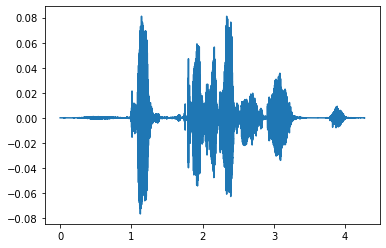

In [12]:
play(dataset[dataset['audio_type'] == 'speech'].iloc[0, :])

Audio Cantado:

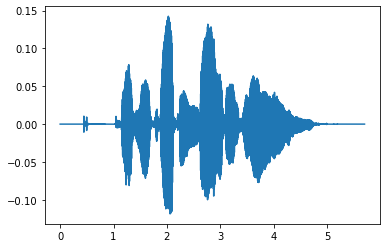

In [13]:
play(dataset[dataset['audio_type'] == 'song'].iloc[0, :])

Quitamos columnas que no vamos usar como:

* file_path, file
* modality:
    * 01 = full-AV
    * 02 = video-only
    * 03 = audio-only
* vocal_channel: esta repetida ya tenemos audio_type.
    * 01 = speech
    * 02 = song
* statement
    * 01 = "Kids are talking by the door"
    * 02 = "Dogs are sitting by the door".
* repetition: 
    * 01 = 1st repetition
    * 02 = 2nd repetition
* start: El momento de inicio siempre es cero.
* end: Es la duracion del audio.

In [14]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file_path',
    'file',
    'modality',
    'vocal_channel',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

In [15]:
examples = dataset[example_columns]

Luego codificamos audio_type como dummy:

In [16]:
examples['audio_type'].value_counts()

speech    1440
song      1012
Name: audio_type, dtype: int64

In [17]:
examples['audio_type'] = pd.get_dummies(examples['audio_type'])

In [18]:
examples['audio_type'].value_counts()

0    1440
1    1012
Name: audio_type, dtype: int64

Analizamos si hay valores faltantes:

In [19]:
missing_values_summary(examples)

Series([], dtype: float64)

Partimos en dev y test:

In [21]:
features = exclude_columns(examples, [target_column])
target   = examples[[target_column]]

In [22]:
random_state = 1
test_size    = 0.3

In [23]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

In [24]:
set_summary(X_dev, y_dev)

- Features shape: (1716, 91)
- Target shape: (1716, 1)
- Target classes:
	- Clase '6': 15.33 %
	- Clase '5': 15.33 %
	- Clase '4': 15.33 %
	- Clase '3': 15.33 %
	- Clase '2': 15.33 %
	- Clase '7': 7.87 %
	- Clase '8': 7.81 %
- Valores faltantes en features: No hay valores faltantes!


In [25]:
set_summary(X_test, y_test)

- Features shape: (736, 91)
- Target shape: (736, 1)
- Target classes:
	- Clase '6': 15.35 %
	- Clase '5': 15.35 %
	- Clase '4': 15.35 %
	- Clase '3': 15.35 %
	- Clase '2': 15.35 %
	- Clase '8': 7.88 %
	- Clase '7': 7.74 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [26]:
cv_strategy_1 = StratifiedKFold(n_splits=12)

In [27]:
def show_score(model, X_dev, y_dev, cv, groups=None, scoring='accuracy', n_jobs=24):
    scores = cross_val_score(
        model, 
        X_dev, 
        y_dev, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=n_jobs, 
        groups=groups
    )
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [28]:
X_Dev_input = exclude_columns(X_dev, ['actor'])

Random Forest:

In [37]:
%%time
show_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.659 (0.050)
CPU times: user 17.3 ms, sys: 3.03 ms, total: 20.3 ms
Wall time: 832 ms


Ada Boost:

In [38]:
%%time
show_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.357 (0.054)
CPU times: user 11.1 ms, sys: 3.4 ms, total: 14.5 ms
Wall time: 716 ms


Gradient Boosting:

In [39]:
%%time
show_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.656 (0.041)
CPU times: user 20.2 ms, sys: 642 µs, total: 20.8 ms
Wall time: 19.9 s


**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [32]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'group'
)
actors_fold_input  = exclude_columns(X_dev_tmp, ['actor', 'group'])
actors_fold_groups = X_dev_tmp['actor']

In [33]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [34]:
%%time
show_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.533 (0.105)
CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 957 ms


Ada Boost:

In [35]:
%%time
show_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.348 (0.077)
CPU times: user 24.6 ms, sys: 265 µs, total: 24.9 ms
Wall time: 885 ms


Gradient Boosting:

In [36]:
%%time
show_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.538 (0.103)
CPU times: user 33.2 ms, sys: 4.45 ms, total: 37.6 ms
Wall time: 26.4 s


#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [57]:
def show_summary(randomized_search, X, y, excluded = ['actor']):
    model = randomized_search.best_estimator_
    print('Hiper parameters:', randomized_search.best_params_)
    print ('Best score:', randomized_search.best_score_)
    print('Accuracy Test: {:.3f} %'.format(model.score(exclude_columns(X, excluded), y) * 100))

In [58]:
def randomized_search(
    model, 
    params_grid, 
    cv, 
    X, 
    y,
    groups  = None, 
    scoring = 'accuracy', 
    n_jobs  = 24, 
    n_iter  = 50, 
    verbose = 1, 
    return_train_score = True
):
    rs = RandomizedSearchCV(
        model,
        params_grid, 
        n_jobs  = n_jobs, 
        scoring = scoring,
        cv      = cv,
        n_iter  = n_iter,
        verbose = verbose,
        return_train_score  = return_train_score
    )
    rs.fit(X, y, groups=groups)
    return rs

Random Forest:

In [59]:
%%time

rs = randomized_search(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.5, 100)
    }, 
)
show_summary(rs, X_test, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   20.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:   37.4s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:  1.0min finished


Hiper parameters: {'max_depth': 21, 'criterion': 'entropy', 'ccp_alpha': 0.03535353535353536}
Best score: 0.3950781239815992
Accuracy Test: 41.712 %
CPU times: user 2.79 s, sys: 101 ms, total: 2.89 s
Wall time: 1min 2s


Ada Boost:

In [62]:
%%time

rs = randomized_search(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
show_summary(rs, X_test, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 256 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 756 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:   12.0s finished


Hiper parameters: {'n_estimators': 18, 'learning_rate': 0.46}
Best score: 0.4023585040685019
Accuracy Test: 41.576 %
CPU times: user 1.11 s, sys: 36.5 ms, total: 1.14 s
Wall time: 12.4 s


Gradient Boosting:

In [64]:
%%time

rs = randomized_search(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
show_summary(rs, X_test, y_test)

Fitting 24 folds for each of 50 candidates, totalling 1200 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   27.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:  2.0min
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:  3.1min finished


Hiper parameters: {'n_estimators': 18, 'learning_rate': 0.159}
Best score: 0.5206693887922738
Accuracy Test: 60.598 %
CPU times: user 5.23 s, sys: 97.3 ms, total: 5.33 s
Wall time: 3min 11s


In [138]:
def plot_cf(model, X, y, labels=[]):
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues)
    classes = np.arange(len(labels))
    plt.xticks(classes, labels)
    plt.yticks(classes, labels)
    plt.show()

In [131]:
speech_indexes   = X_test['audio_type'] == 0
speechs_features = exclude_columns(X_test[speech_indexes], 'actor')
speechs_true     = y_test[speech_indexes]

speechs_true.value_counts()

emotion
4          62
8          58
5          58
2          58
7          57
3          57
6          52
1          28
dtype: int64

In [132]:
song_indexes   = X_test['audio_type'] == 1
songs_features = exclude_columns(X_test[song_indexes], 'actor')
songs_true     = y_test[song_indexes]

songs_true.value_counts()

emotion
6          61
3          56
5          55
2          55
4          51
1          28
dtype: int64

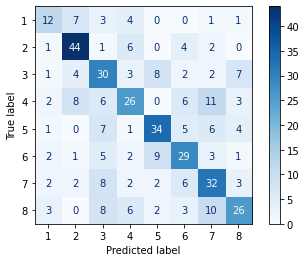

In [139]:
plot_cf(rs.best_estimator_, speechs_features, speechs_true)

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (8).

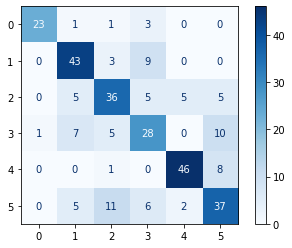

In [141]:
plot_cf(rs.best_estimator_, songs_features, songs_true)